Epoch 0, Loss: 2.0142
Epoch 2, Loss: 1.8093
Epoch 4, Loss: 1.7450
Epoch 6, Loss: 1.6875
Epoch 8, Loss: 1.6663
Epoch 10, Loss: 1.6100
Epoch 12, Loss: 1.5744
Epoch 14, Loss: 1.5427
Epoch 16, Loss: 1.5190
Epoch 18, Loss: 1.4822
Epoch 20, Loss: 1.4501
Epoch 22, Loss: 1.4216
Epoch 24, Loss: 1.3962
Epoch 0, Loss: 2.5668
Epoch 2, Loss: 2.3234
Epoch 4, Loss: 2.2124
Epoch 6, Loss: 2.1248
Epoch 8, Loss: 2.0459
Epoch 10, Loss: 1.9621
Epoch 12, Loss: 1.8960
Epoch 14, Loss: 1.8364
Epoch 16, Loss: 1.7649
Epoch 18, Loss: 1.7133
Epoch 20, Loss: 1.6509
Epoch 22, Loss: 1.6025
Epoch 24, Loss: 1.5556


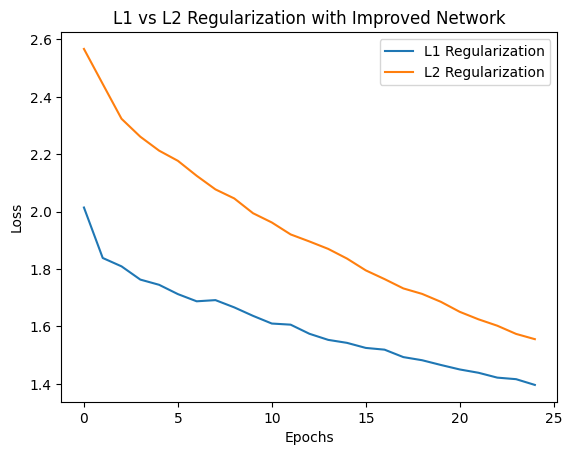

Test Accuracy of L1: 0.8727
Test Accuracy of L2: 0.8752


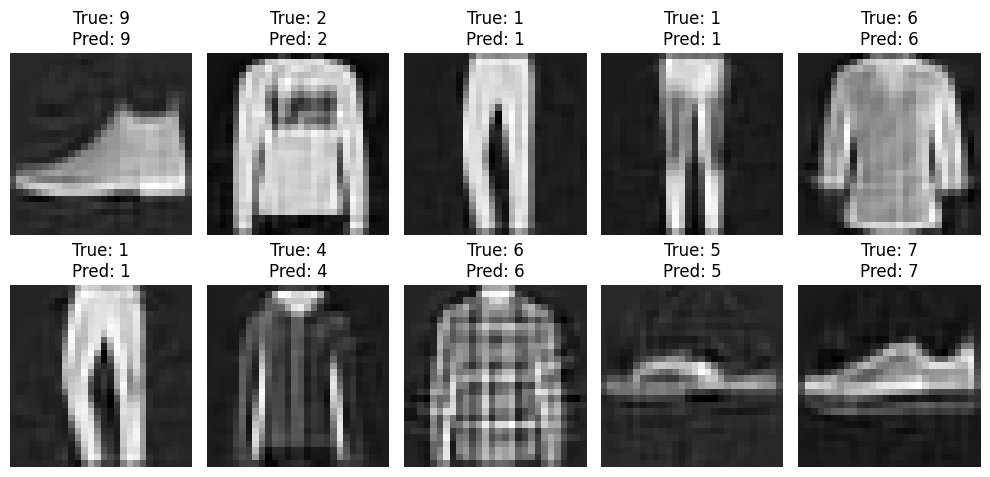

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import fashion_mnist # type: ignore

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Reshape and normalize the dataset
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0  # Normalize to [0, 1] range
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

pca = PCA(n_components=150)  # Reduce to 150 components (this can be tuned)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# One-hot encode the labels
def one_hot_encode(y, cloth_classes):
    return np.eye(cloth_classes)[y]

y_train_encode = one_hot_encode(y_train, 10)
y_test_encode = one_hot_encode(y_test, 10)

class NN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001, l1_lambda=0.0, l2_lambda=0.0, dropout_rate=0.2):
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)  # Xavier Initialization
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.loss_history = []
        self.dropout_rate = dropout_rate

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / (np.sum(exp_x, axis=1, keepdims=True) + 1e-10)

    def relu(self, x):
        return np.maximum(0, x)

    def batch_normalize(self, X, epsilon=1e-8):
        mean = np.mean(X, axis=0)
        variance = np.var(X, axis=0)
        return (X - mean) / np.sqrt(variance + epsilon)

    def dropout(self, X):
        mask = np.random.binomial(1, 1 - self.dropout_rate, size=X.shape)
        return X * mask / (1 - self.dropout_rate)

    def forward(self, X, apply_dropout=True):
        # Input -> Hidden Layer
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.batch_normalize(self.z1))
        if apply_dropout:
            self.a1 = self.dropout(self.a1)

        # Hidden Layer -> Output Layer
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def backward(self, X, y, output):
        m = X.shape[0]
        output_error = output - y
        hidden_error = np.dot(output_error, self.W2.T) * (self.z1 > 0)  # ReLU derivative

        dW2 = np.dot(self.a1.T, output_error) / m
        db2 = np.sum(output_error, axis=0, keepdims=True) / m
        dW1 = np.dot(X.T, hidden_error) / m
        db1 = np.sum(hidden_error, axis=0, keepdims=True) / m

        # L1 regularization
        dW1 += self.l1_lambda * np.sign(self.W1)
        dW2 += self.l1_lambda * np.sign(self.W2)

        # L2 regularization
        dW1 += self.l2_lambda * self.W1
        dW2 += self.l2_lambda * self.W2

        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def train(self, X, y, epochs, batch_size=512, patience=10, regularization_type="L2"):
        best_loss = float('inf')
        wait = 0

        for epoch in range(epochs):
            # Mini-batch Gradient Descent
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]

                output = self.forward(X_batch)
                self.backward(X_batch, y_batch, output)

            # Calculate loss with regularization penalties
            output_full = self.forward(X, apply_dropout=False)
            if regularization_type == "L1":
                penalty = self.l1_lambda * (np.sum(np.abs(self.W1)) + np.sum(np.abs(self.W2)))
            else:  # L2 Regularization by default
                penalty = self.l2_lambda * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))

            loss = -np.mean(np.sum(y * np.log(output_full + 1e-10), axis=1)) + penalty
            self.loss_history.append(loss)

            if epoch % 2== 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

            # Early Stopping
            if loss < best_loss:
                best_loss = loss
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

            # Learning rate decay
            self.learning_rate *= 0.99

    def predict(self, X):
        output = self.forward(X, apply_dropout=False)
        return np.argmax(output, axis=1)

# Instantiate and Train the network
nn_l1 = NN(input_size=150, hidden_size=1024, output_size=10, learning_rate=0.2, l1_lambda=0.0001, dropout_rate=0.2)
nn_l2 = NN(input_size=150, hidden_size=1024, output_size=10, learning_rate=0.2, l2_lambda=0.001, dropout_rate=0.2)

epochs = 25
nn_l1.train(x_train_pca, y_train_encode, epochs=epochs, batch_size=1024, patience=50, regularization_type="L1")
nn_l2.train(x_train_pca, y_train_encode, epochs=epochs, batch_size=1024, patience=50, regularization_type="L2")

# Plot Loss Curves
plt.plot(nn_l1.loss_history, label='L1 Regularization')
plt.plot(nn_l2.loss_history, label='L2 Regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('L1 vs L2 Regularization with Improved Network')
plt.legend()
plt.show()

# Test accuracy
predictions = nn_l1.predict(x_test_pca)
accuracy_l1 = np.mean(predictions == y_test)
print(f"Test Accuracy of L1: {accuracy_l1:.4f}")

predictions = nn_l2.predict(x_test_pca)
accuracy_l2 = np.mean(predictions == y_test)
print(f"Test Accuracy of L2: {accuracy_l2:.4f}")

# Plot predictions
def plot_predictions(X, y_true, y_pred, num_images=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(pca.inverse_transform(X[i]).reshape(28, 28), cmap='gray')
        plt.title(f'True: {y_true[i]}\nPred: {y_pred[i]}') 
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions(x_test_pca, y_test, predictions)
